## 一，准备数据

In [1]:
import os
import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import datasets,layers,models

In [2]:
## http://d0evi1.com/tensorflow/datasets_performance/ 介绍了pipline
BATCH_SIZE = 100

def load_image(img_path, size=(32,32)):
    label = tf.constant(1,tf.int8) \
        if tf.strings.regex_full_match(img_path,".*automobile.*") \
            else tf.constant(0,tf.int8)
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img) #注意此处为jpeg格式
    img = tf.image.resize(img,size)/255.0
    return(img,label)

## num_parallel_calls一般设置为cpu核心数量
ds_train = tf.data.Dataset.list_files('../../../data/cifar2/train/*/*.jpg') \
    .map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
        .shuffle(buffer_size=1000).batch(BATCH_SIZE) \
            .prefetch(tf.data.experimental.AUTOTUNE)
ds_test = tf.data.Dataset.list_files('../../../data/cifar2/test/*/*.jpg') \
    .map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
        .batch(BATCH_SIZE) \
            .prefetch(tf.data.experimental.AUTOTUNE)

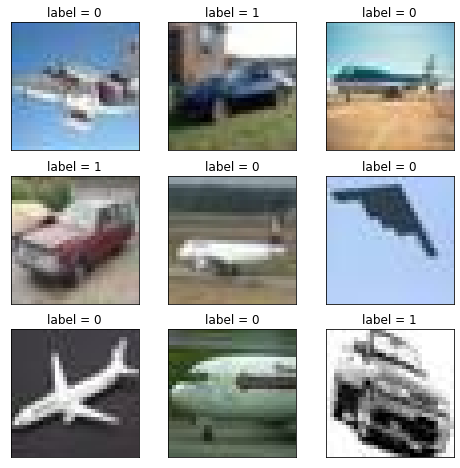

In [3]:
plt.figure(figsize=(8,8))
for i,(img,label) in enumerate(ds_train.unbatch().take(9)):
    ax = plt.subplot(3,3,i+1)
    ax.imshow(img.numpy())
    ax.set_title("label = %d" % label)
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

In [4]:
for x, y in ds_train.take(1):
    print(x.shape, y.shape)

(100, 32, 32, 3) (100,)


## 二，定义模型

In [5]:
tf.keras.backend.clear_session()

inputs = layers.Input(shape=(32,32,3))
x = layers.Conv2D(32, kernel_size=(3,3))(inputs) # 896=3*32*9+32
x = layers.MaxPool2D()(x)
x = layers.Conv2D(64, kernel_size=(5,5))(x) # 51264=32*64*25+64
x = layers.MaxPool2D()(x)
x = layers.Dropout(rate=0.1)(x)
x = layers.Flatten()(x) # 1600=5*5*64
x = layers.Dense(32, activation='relu')(x) # 51232=1600*32*1+32
outputs = layers.Dense(1, activation='sigmoid')(x) # 33=32+1

model = models.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0     

## 三，训练模型

In [6]:
stamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = os.path.join('data', 'autograph', stamp)

tensorboard_callback = tf.keras.callbacks.TensorBoard(
    logdir, 
    histogram_freq=1
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.binary_crossentropy,
    metrics=['accuracy']
)

history = model.fit(
    ds_train,
    epochs=10,
    validation_data=ds_test,
    callbacks=[tensorboard_callback],
    workers=4
)

Train for 100 steps, validate for 20 steps
Epoch 1/10
100/100 [==============================] - 6s 59ms/step - loss: 0.4313 - accuracy: 0.7901 - val_loss: 0.3275 - val_accuracy: 0.8590
Epoch 2/10
100/100 [==============================] - 4s 37ms/step - loss: 0.3142 - accuracy: 0.8648 - val_loss: 0.2584 - val_accuracy: 0.8900
Epoch 3/10
100/100 [==============================] - 4s 37ms/step - loss: 0.2521 - accuracy: 0.8942 - val_loss: 0.2094 - val_accuracy: 0.9125
Epoch 4/10
100/100 [==============================] - 4s 37ms/step - loss: 0.2053 - accuracy: 0.9197 - val_loss: 0.1919 - val_accuracy: 0.9255
Epoch 5/10
100/100 [==============================] - 4s 35ms/step - loss: 0.1782 - accuracy: 0.9310 - val_loss: 0.1848 - val_accuracy: 0.9245
Epoch 6/10
100/100 [==============================] - 4s 36ms/step - loss: 0.1515 - accuracy: 0.9411 - val_loss: 0.1782 - val_accuracy: 0.9305
Epoch 7/10
100/100 [==============================] - 3s 35ms/step - loss: 0.1360 - accuracy: 0.946

## 四，评估模型

In [8]:
dfhistory = pd.DataFrame(history.history)
dfhistory.index = range(1, len(dfhistory)+1)
dfhistory.index.name = 'epoch'

dfhistory

,loss,accuracy,val_loss,val_accuracy
epoch,,,,
1,0.431298,0.7901,0.327532,0.8590
2,0.314170,0.8648,0.258377,0.8900
3,0.252102,0.8942,0.209436,0.9125
4,0.205333,0.9197,0.191918,0.9255
5,0.178215,0.9310,0.184773,0.9245
6,0.151464,0.9411,0.178217,0.9305
7,0.136008,0.9462,0.162586,0.9360
8,0.115437,0.9572,0.183983,0.9215
9,0.099999,0.9629,0.168983,0.9340


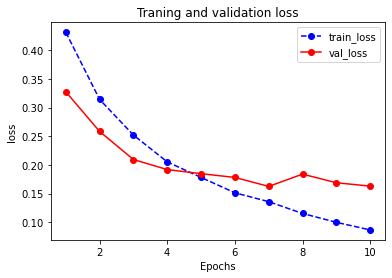

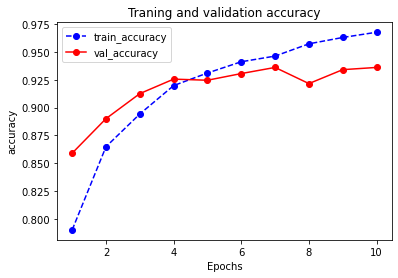

In [11]:
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics)+1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Traning and validation ' + metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend(["train_"+metric, "val_"+metric])
    plt.show()

plot_metric(history, 'loss')
plot_metric(history, 'accuracy')

In [12]:
val_loss, val_accuracy = model.evaluate(ds_test, workers=4)
print(val_loss, val_accuracy)

20/20 [==============================] - 1s 33ms/step - loss: 0.1631 - accuracy: 0.9360
0.1630685966461897 0.936


## 五，使用模型

In [13]:
model.predict(ds_test)

array([[2.2250642e-03],
       [1.2392626e-04],
       [7.9163194e-01],
       ...,
       [3.1757576e-03],
       [2.2469566e-03],
       [9.9980158e-01]], dtype=float32)

In [41]:
for x,y in ds_test.take(1):
    print(model.predict_on_batch(x[:20]))

tf.Tensor(
[[9.1265088e-01]
 [9.9891937e-01]
 [9.9999964e-01]
 [1.4763097e-04]
 [9.9999928e-01]
 [7.9383604e-02]
 [1.0000000e+00]
 [9.9784791e-01]
 [1.2953528e-03]
 [2.4915852e-03]
 [7.6347910e-02]
 [9.9996114e-01]
 [3.1967070e-02]
 [9.8360586e-01]
 [9.2779279e-01]
 [9.9625301e-01]
 [9.9999785e-01]
 [9.9863416e-01]
 [1.4826101e-03]
 [8.2671803e-01]], shape=(20, 1), dtype=float32)


## 六，保存模型

In [42]:
model.save_weights(
    './tf_model_weights.ckpt',
    save_format='tf'
    )

In [43]:
model.save(
    './tf_model_savedmodel', 
    save_format='tf'
    )
print('export saved model.')
model_loaded = tf.keras.models.load_model('./tf_model_savedmodel')
model_loaded.evaluate(ds_test)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./tf_model_savedmodel\assets
export saved model.
20/20 [==============================] - 1s 40ms/step - loss: 0.1631 - accuracy: 0.9360


[0.16306831128895283, 0.936]